Generative Adversarial Networks

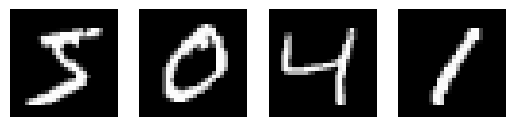

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU # relu versiyonudur. girdi +x ise +x verir, -x ise -ax iler çarpımını verir, a = çok kücük bir degerdir
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm # for dongusune ilerleme sayaci ekler

import warnings
warnings.filterwarnings("ignore")

# veri setini yükle
(x_train, _), (_, _) = mnist.load_data()

#normalizasyon
x_train = x_train.astype('float32') / 255.0

#boyutların ayarlanması(28x28) -> (28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)


plt.figure()
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')

8.3

In [13]:
# gan param
z_dim = 200 # gurultu vektorunun boyutu

# discriminator modeline tanımla
def build_disc():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides = 2 , padding='same', input_shape = ( 28,28,1 )))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))  # Dropout ekledik

    model.add(Conv2D(128, kernel_size=3, strides = 2 , padding='same'))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))  # Dropout ekledik

    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))

    model.compile(loss = "binary_crossentropy", optimizer = Adam(0.0002, 0.5), metrics = ['accuracy']) # 0.0002 = learning rate, 0.5 = beta_1

    return model

# generator modeline tanımla
def build_gen():
    model = Sequential()
    model.add(Dense(7*7*256, input_dim=z_dim))  # 128'den 256'ya çıkardık
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,256)))
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))  # Yeni katman
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))  # Önceki katman
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))  # Yeni katman
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(1, kernel_size=3, strides=1, padding='same', activation='tanh'))

    return model


8.4

In [14]:
def build_gan(gen, disc):
    disc.trainable = False # discriminator modeli eğitilmez

    model = Sequential()
    model.add(gen) # generator modeli
    model.add(disc) # discriminator modeli
    model.compile(loss = "binary_crossentropy", optimizer = Adam(0.0002, 0.5))
    return model

disc = build_disc()
gen = build_gen()
gan = build_gan(gen, disc)
print(gan.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)       │ (None, 28, 28, 1)      │     2,910,849 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 1)              │        80,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,991,618 (11.41 MB)

 Trainable params: 2,909,889 (11.10 MB)

 Non-trainable params: 81,729 (319.25 KB)

None


8.5.6

In [15]:
epochs = 4000

batch_size = 64
half_batch = batch_size // 2

for epoch in tqdm(range(epochs), desc="Traiding Process"):

    idx = np.random.randint(0, x_train.shape[0], half_batch)
    real_imgs = x_train[idx]
    real_labels = np.ones((half_batch, 1)) # gerçek resimler için etiketler

    noise = np.random.normal(0, 1, (half_batch, z_dim))
    fake_imgs = gen.predict(noise, verbose=0)
    fake_labels = np.zeros((half_batch, 1)) # sahte resimler için etiketler

    d_loss_real = disc.train_on_batch(real_imgs, real_labels)
    d_loss_fake = disc.train_on_batch(fake_imgs, fake_labels)
    d_loss = np.add(d_loss_real, d_loss_fake) * 0.5

    noise = np.random.normal(0, 1, (batch_size, z_dim))
    valid_y = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_y)

    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} [D loss: {d_loss[0]} - D accuracy: {100*d_loss[1]}] [G loss: {g_loss}]")

Traiding Process:   0%|          | 1/4000 [00:03<4:14:22,  3.82s/it]

Epoch: 0 [D loss: 0.6879265308380127 - D accuracy: 54.6875] [G loss: 0.6730931997299194]


Traiding Process:  25%|██▌       | 1001/4000 [05:50<19:46,  2.53it/s]

Epoch: 1000 [D loss: 1.218122124671936 - D accuracy: 34.06507873535156] [G loss: 0.17196530103683472]


Traiding Process:  50%|█████     | 2001/4000 [12:29<13:03,  2.55it/s]

Epoch: 2000 [D loss: 1.3160632848739624 - D accuracy: 34.17078399658203] [G loss: 0.14864860475063324]


Traiding Process:  75%|███████▌  | 3001/4000 [19:05<06:55,  2.41it/s]

Epoch: 3000 [D loss: 1.3497414588928223 - D accuracy: 34.18624496459961] [G loss: 0.14061111211776733]


Traiding Process: 100%|██████████| 4000/4000 [25:55<00:00,  2.57it/s]


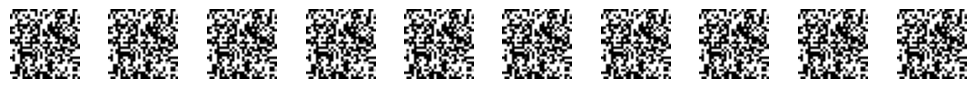

In [16]:
def plot_gen(gen, epoch, examples=10, dim=(1, 10)):

    noise = np.random.normal(0, 1, size=[examples, z_dim])
    generated_imgs = gen.predict(noise,verbose=0)
    generated_imgs = 0.5*generated_imgs + 0.5

    plt.figure(figsize=(10, 1))
    for i in range(generated_imgs.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_imgs[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"gan_generated_image_epoch_{epoch}.png")
    plt.show()
plot_gen(gen, epochs)